# Lab notebook Modelling of differential LaminB2 interaction on TopB2 knock-down

In [3]:
%reset
import pandas as pd
import numpy  as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import minimize
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#from scipy import stats
#from sklearn.neighbors import KernelDensity

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Data preprocessing

In [6]:
# Load table
infile='../results/Tracks_80kb.txt'
tables = {}
tables['Tracks'] = pd.read_csv(infile,sep='\t')

# remove expreme Top2 ( < -2 )
idx_out = tables['Tracks'].Top2[tables['Tracks'].Top2 < -2 ].index
tables['Tracks'].loc[idx_out,'Top2'] = tables['Tracks'].Top2.mean()

# get variables
CHR = [f'chr{i+1}' for i in range(22)] + ['chrX','chrY']
my_variables = tables['Tracks'].columns[3:]

# binning
if True:
  bin = 4 # 80kbp per bin
  bin_size_kb = int(bin*20)
  print(f'Binning: {bin*20}kbp')
  tables['Binned'] = pd.DataFrame()
  for c in CHR:
    l = len(tables['Tracks'][tables['Tracks'].chr==c])
    my_chr = tables['Tracks'][tables['Tracks'].chr==c].iloc[np.arange(0,l,bin),0].values
    my_start = tables['Tracks'][tables['Tracks'].chr==c].iloc[np.arange(0,l,bin),1].values
    my_end = tables['Tracks'][tables['Tracks'].chr==c].iloc[np.minimum(np.arange(0,l,bin)+bin-1,l-1),2].values
    data = {'chr':my_chr,'start':my_start,'end':my_end}
    df = pd.DataFrame(data=data)

    my_values = tables['Tracks'][tables['Tracks'].chr==c].iloc[:,3:]
    avg_idx = [bin*[i] for i in range(l//bin+1)]
    avg_idx = [i for j in avg_idx for i in j]
    avg_idx = avg_idx[:l]
    my_values = my_values.groupby(avg_idx).mean()

    my_df = df.join( pd.DataFrame(my_values,columns=my_variables) )
    tables['Binned'] = pd.concat([tables['Binned'],my_df])
  tables['Binned'].reset_index(inplace=True,drop=True)
  tables['Binned'] = tables['Binned'].dropna()
else:
  tables['Binned'] = tables['Tracks']

# smoothing
win = 10
tables['Smoothed'] = pd.DataFrame()
CHR = [f'chr{i+1}' for i in range(22)] + ['chrX','chrY']
for c in CHR:
  #Smoothed = pd.concat([Smoothed,Tracks[Tracks.chr==c][['Top2', 'RNAseq1', 'RNAseq2', 'H3K9me2_wt', 'H3K9me2_kd', 'H3K9me3_wt', 'H3K9me3_kd', 'RNAseq', 'H3K9me2', 'H3K9me3']].rolling(window=win).mean().dropna()])
  #Smoothed = pd.concat([Smoothed,Binned[Binned.chr==c][['Delta_Lmnb2','Top2','H3K9me2','H3K9me3']].ewm(halflife=win/2).mean()])
  #tables['Smoothed'] = pd.concat([tables['Smoothed'],tables['Binned'][tables['Binned'].chr==c][['Delta_Lmnb2','Top2','H3K9me2','H3K9me3','H3K9me2_wt','H3K9me3_wt','H3K9me2_ko','H3K9me3_ko']].rolling(window=win).mean()])
  tables['Smoothed'] = pd.concat([tables['Smoothed'],tables['Binned'][tables['Binned'].chr==c][my_variables].ewm(halflife=win/2).mean()])
tables['Smoothed'] = tables['Binned'][['chr','start','end']].join(tables['Smoothed']).dropna()

# remove any nan and normalize (Z-score) (All but Delta_Lmnb2)
to_norm = list(set(my_variables) - {'Delta_Lmnb2','Delta_Ste_supercoiling'})
for my_table in tables.keys():
  tables[my_table].dropna(how='any',inplace=True)
  tables[my_table].reset_index(inplace=True,drop=True)
  
  #norm
  X = tables[my_table].loc[:,to_norm].values
  tables[my_table].loc[:,to_norm] = (X - np.mean(X,axis=0))/np.std(X,axis=0)
  
  
SSR = {}
SST = {}
R2 = {}
df = {}
Spearman = {}

for my_table in ['Tracks','Binned','Smoothed']:
  y = tables[my_table].Delta_Lmnb2
  SST[my_table] = np.sum((y-np.mean(y))**2)
  
print('done')

Binning: 80kbp
done


## Biplots

Delta_Lmnb2
Gilbert_supercoiling
Ste_supercoiling_wt
Delta_Ste_supercoiling
H3K9me2_wt
H3K9me2_ko
H3K9me2
Delta_H3K9me2
H3K9me3
Top2
RNAseq
Delta_Lmnb2
Gilbert_supercoiling
Ste_supercoiling_wt
Delta_Ste_supercoiling
H3K9me2_wt
H3K9me2_ko
H3K9me2
Delta_H3K9me2
H3K9me3
Top2
RNAseq


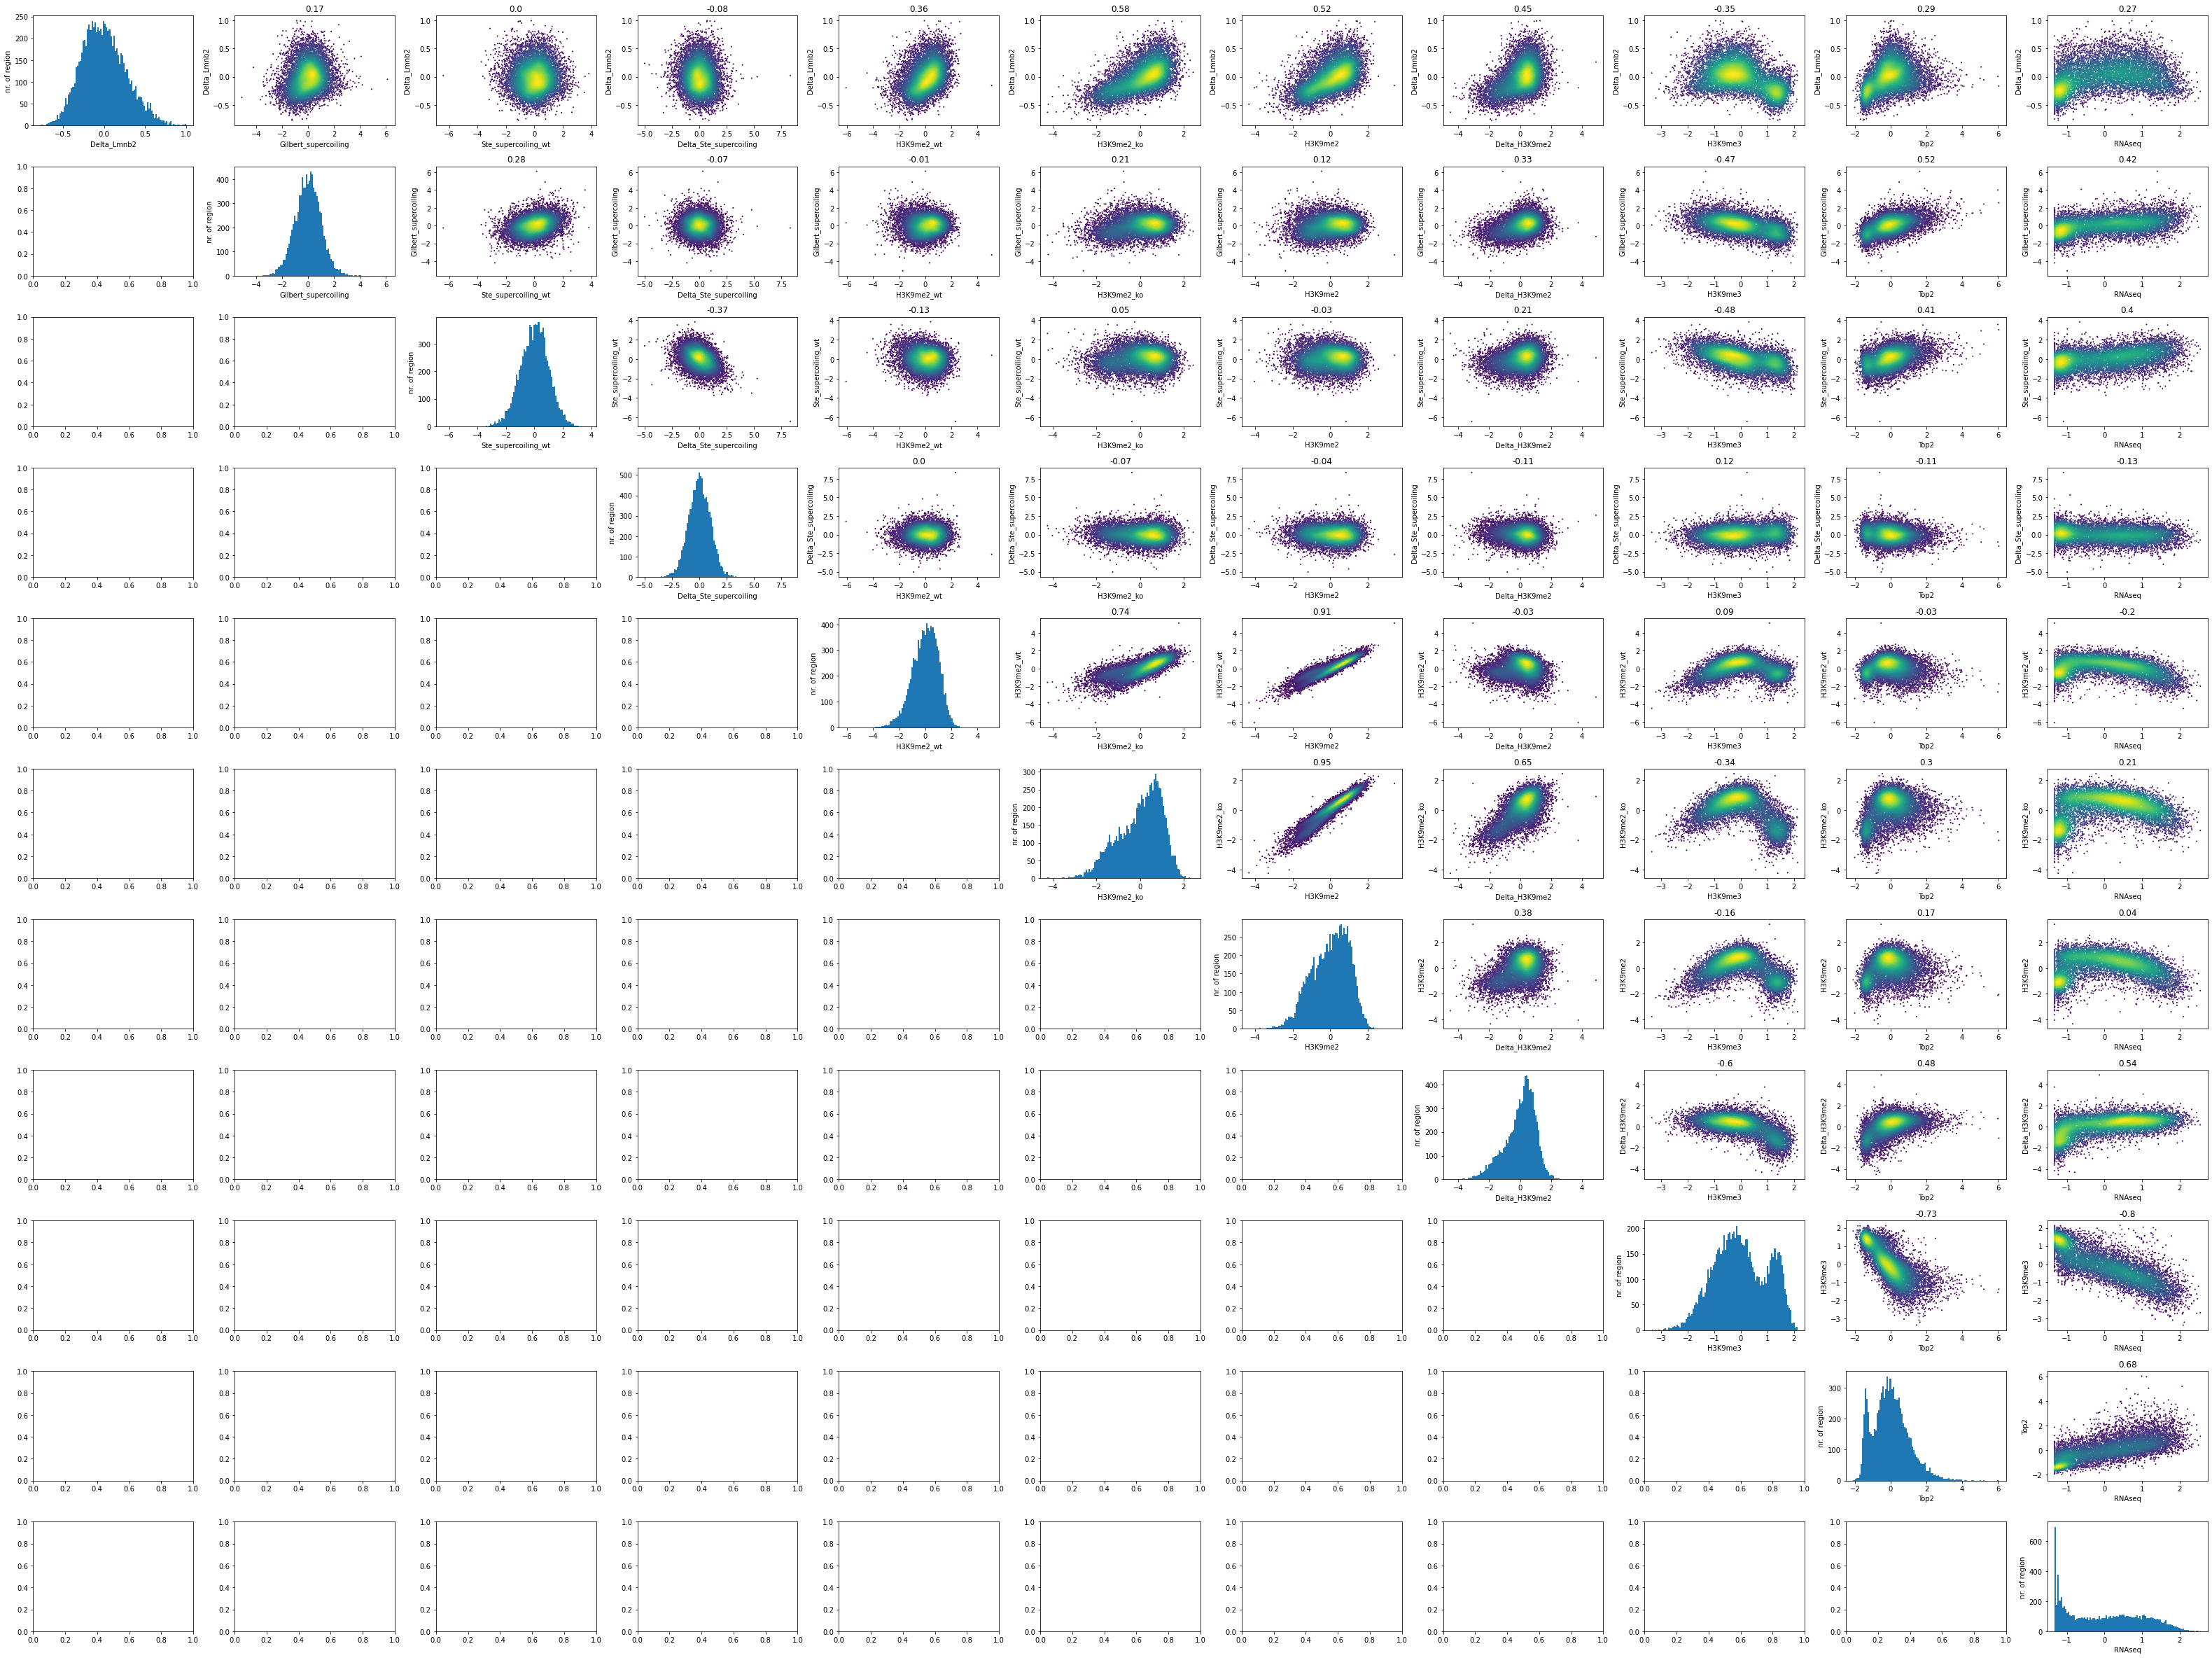

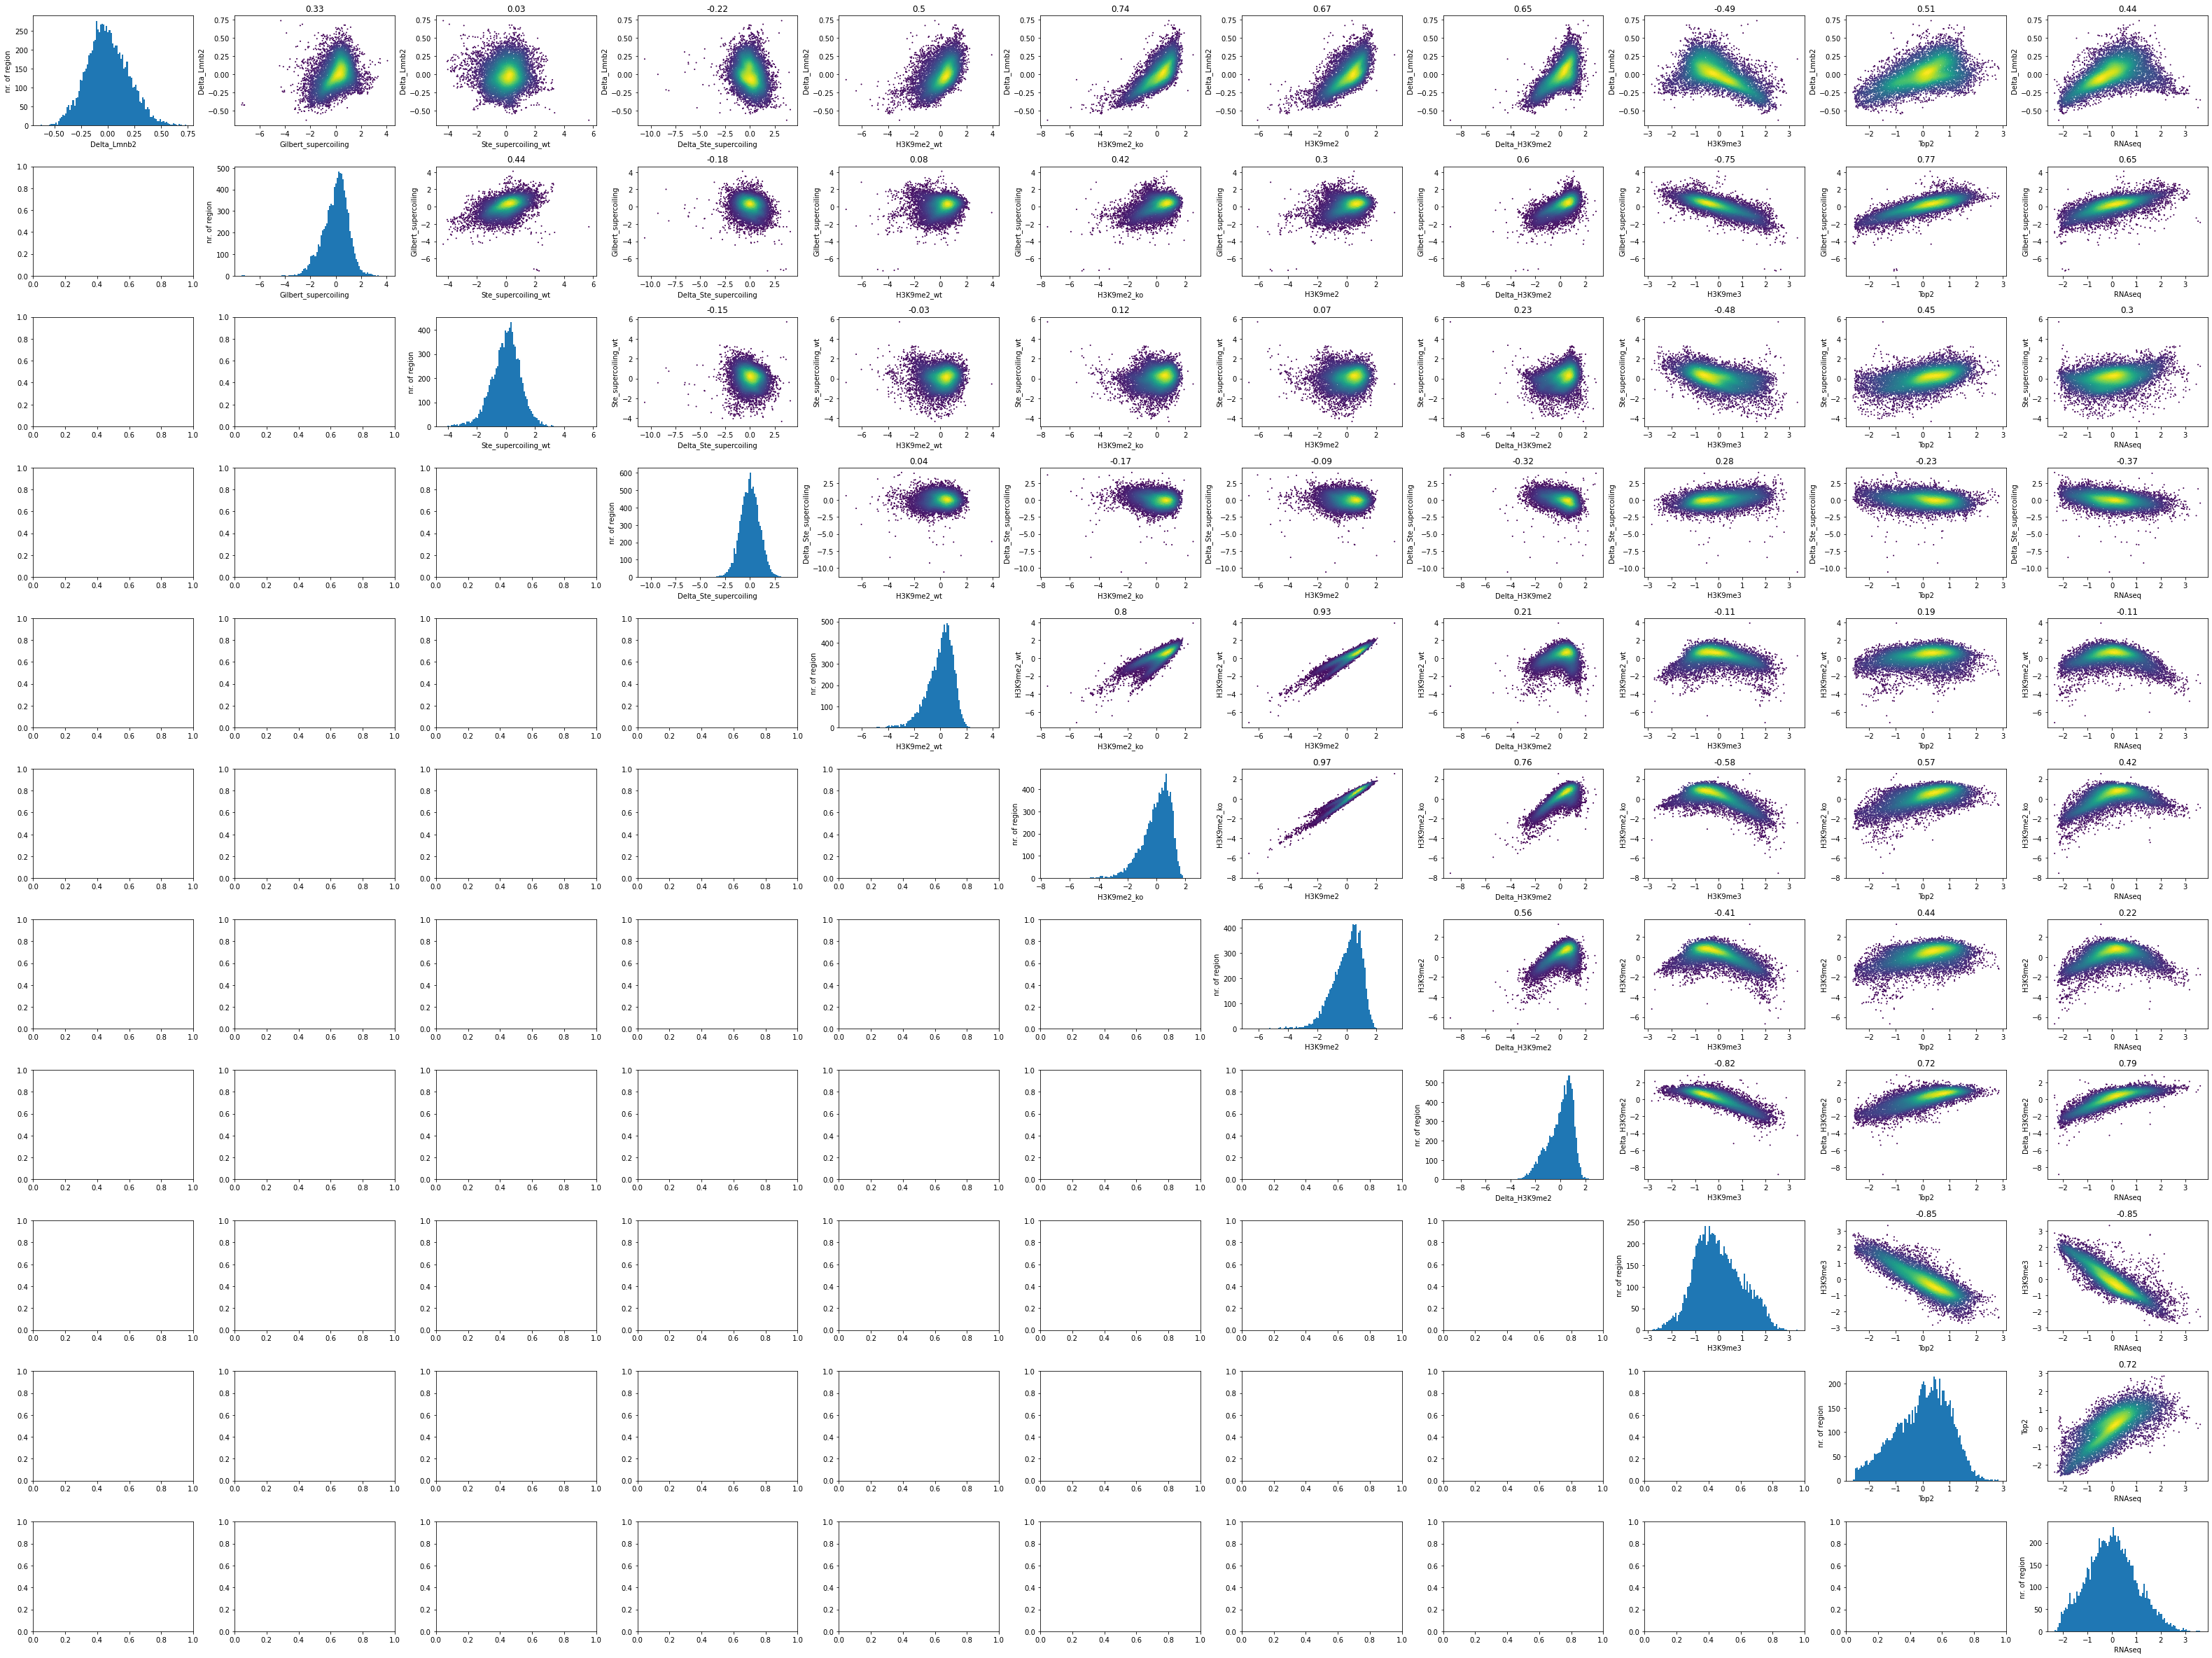

In [10]:
table_cols = ['Delta_Lmnb2','Gilbert_supercoiling','Ste_supercoiling_wt','Delta_Ste_supercoiling','H3K9me2_wt','H3K9me2_ko','H3K9me2','Delta_H3K9me2','H3K9me3','Top2','RNAseq']

for my_table in ['Binned','Smoothed']:
  fig = plt.figure()
  rows = len(table_cols)
  cols = rows
  f=0

  for i,t1 in enumerate(table_cols):
    print(t1)
    for j,t2 in enumerate(table_cols):
      f+=1
      ax = fig.add_subplot(rows,cols,f)
      
      if i==j:

        a = ax.hist(tables[my_table][t1],100)
        ax.set_xlabel(t1)
        ax.set_ylabel('nr. of region')
      elif i<j:
        xy = np.vstack([tables[my_table][t2].values,tables[my_table][t1].values])
        z = gaussian_kde(xy)(xy)
        #z = tables[my_table]['Top2']
        ax.scatter(tables[my_table][t2],tables[my_table][t1],c=z,s=1)
        ax.set_xlabel(t2)
        ax.set_ylabel(t1)
        r = np.corrcoef(tables[my_table][t2],tables[my_table][t1])[0,1]
        ax.set_title(np.round(r,2))
  
  fig.set_size_inches([cols*4,rows*3])
  plt.tight_layout()

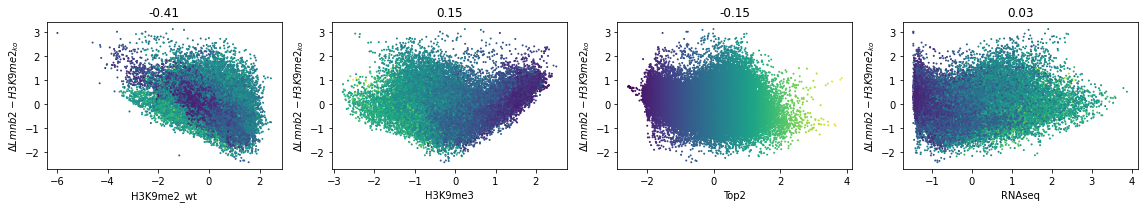

In [144]:
my_table = 'Smoothed'
y_val = tables[my_table]['Delta_Lmnb2'].values - tables[my_table]['H3K9me2_ko'].values
table_cols = ['H3K9me2_wt','H3K9me3','Top2','RNAseq']

fig = plt.figure()
rows = 1
cols = len(table_cols)
f=0

for j,t2 in enumerate(table_cols):
  f+=1
  ax = fig.add_subplot(rows,cols,f)

  #xy = np.vstack([tables[my_table][t2].values,y_val)
  #z = gaussian_kde(xy)(xy)
  z = tables[my_table]['Top2']
  ax.scatter(tables[my_table][t2],y_val,c=z,s=1)
  ax.set_xlabel(t2)
  ax.set_ylabel('$\Delta Lmnb2 - H3K9me2_{ko}$')
  r = np.corrcoef(tables[my_table][t2],y_val)[0,1]
  ax.set_title(np.round(r,2))

fig.set_size_inches([cols*4,rows*3])
plt.tight_layout()

## PCA

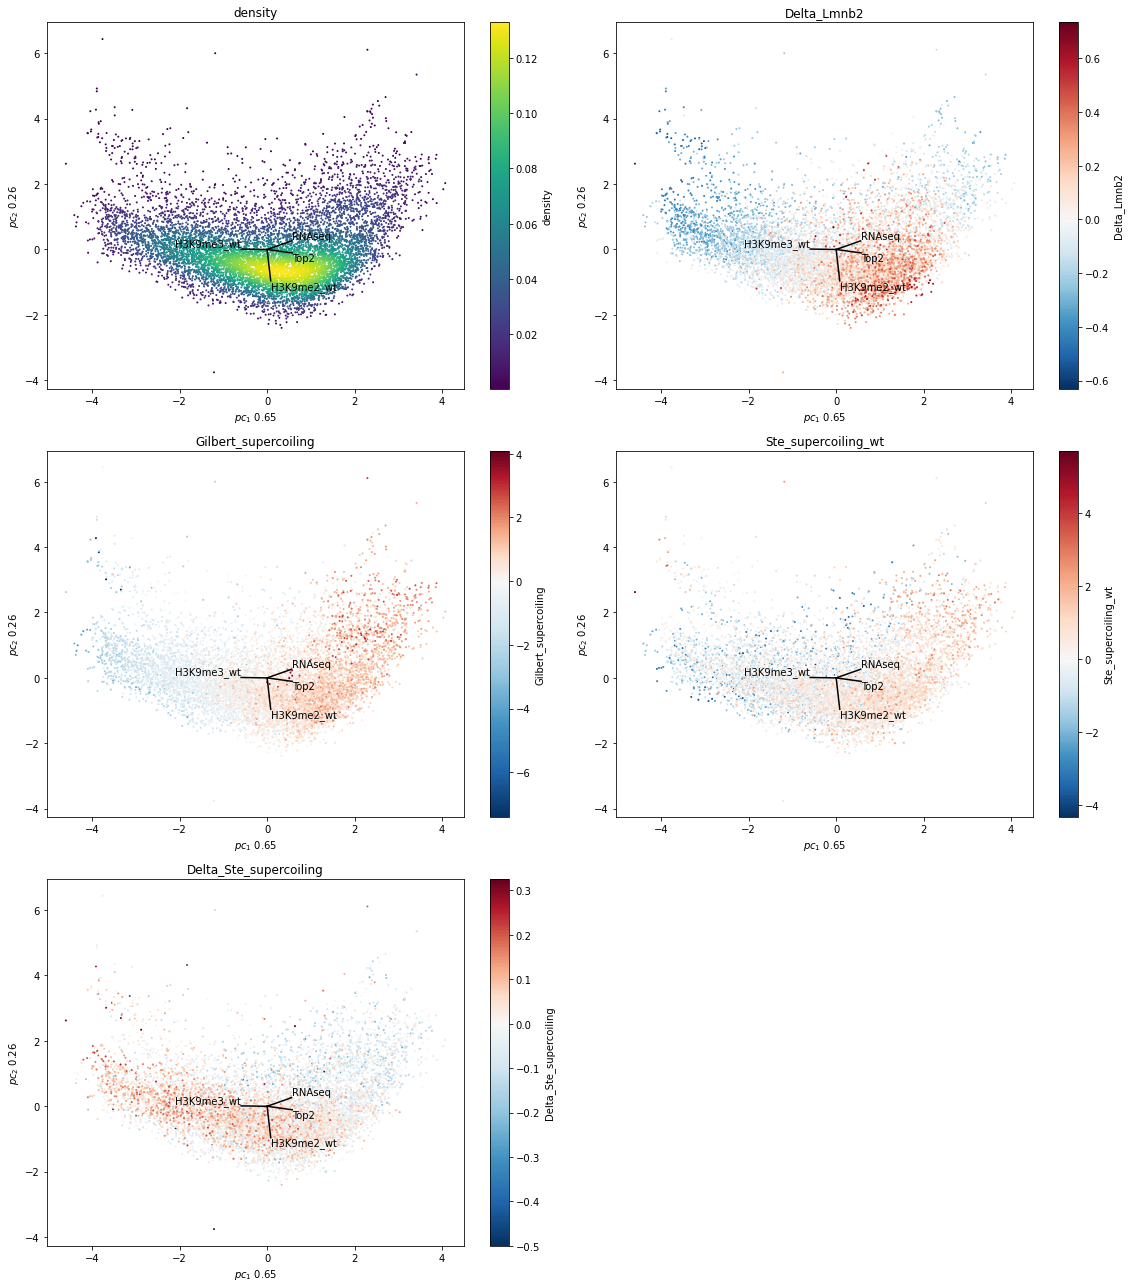

In [6]:
table_cols = ['Delta_Lmnb2','Top2','H3K9me2_wt','H3K9me2_ko','H3K9me3','RNAseq']
table_cols = ['Top2','H3K9me2_wt','H3K9me3_wt','RNAseq']
color_by = ['density','Delta_Lmnb2','Gilbert_supercoiling','Ste_supercoiling_wt','Delta_Ste_supercoiling']
my_table = 'Smoothed'

fig = plt.figure()
rows = 3
cols = 2
f=0

X = tables[my_table][table_cols].values
[U,S,V] = np.linalg.svd(X,full_matrices=False)
sing_values = S**2
pc_var = sing_values/np.sum(sing_values)
score = np.dot(U,np.diag(S))

for col in color_by:

  f+=1
  ax = fig.add_subplot(rows,cols,f)
  if col == 'density':
    z = gaussian_kde(score[:,[0,1]].T)(score[:,[0,1]].T)
    idx_sort = np.arange(z.shape[0])
    a = ax.scatter(x=score[idx_sort,0],y=score[idx_sort,1],c=z[idx_sort],s=1,alpha=1,cmap='viridis',rasterized=True)
  else:
    z = tables[my_table][col]
    idx_sort = np.argsort(z)
    if col == 'Delta_Ste_supercoiling':
      divnorm = mpl.colors.TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=np.max(z))
    else:
      divnorm = mpl.colors.TwoSlopeNorm(vmin=np.min(z), vcenter=0, vmax=np.max(z))
    a = ax.scatter(x=score[idx_sort,0],y=score[idx_sort,1],c=z[idx_sort],s=1,alpha=1,cmap='RdBu_r',norm=divnorm,rasterized=True)
  cbar = plt.colorbar(a)
  cbar.set_label(col)
  for d in range(V.shape[1]):
    x = [0,V[0,d]]
    y = [0,V[1,d]]
    ax.plot(x,y,'k-')
    if x[1]<0:
      ha='right'
    else:
      ha='left'
    if y[1]<0:
      va='top'
    else:
      va='bottom'

    ax.text(x[1],y[1],table_cols[d],ha=ha,va=va,color='k')
  ax.set_xlabel(f'$pc_1$ {np.round(pc_var[0],2)}')
  ax.set_ylabel(f'$pc_2$ {np.round(pc_var[1],2)}')
  ax.set_title(col)

fig.set_size_inches([cols*8,rows*6])
plt.tight_layout()
fig.savefig(f'/home/j.breda/Workspace/Modelling_Lmnb2_Top2_H3K9me2_H3K9me3_jb20220802/fig/pca_{my_table}_{bin_size_kb}.pdf')

Smoothed
Smoothed


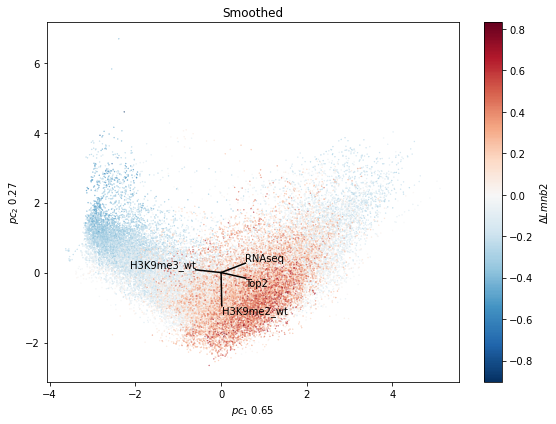

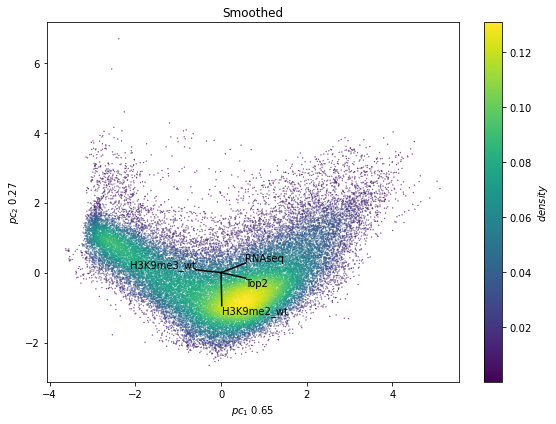

In [59]:
table_cols = ['Top2','RNAseq','H3K9me2_wt','H3K9me3_wt']
for my_table in ['Smoothed']:#['Tracks','Binned','Smoothed']:
  print(my_table)
  X = tables[my_table][table_cols].values
  [U,S,V] = np.linalg.svd(X,full_matrices=False)
  sing_values = S**2
  pc_var = sing_values/np.sum(sing_values)
  score = np.dot(U,np.diag(S))

  fig = plt.figure()
  rows = 1
  cols = 1
  f=0

  f+=1
  ax = fig.add_subplot(rows,cols,f)
  z = tables[my_table]['Delta_Lmnb2']
  idx_sort = np.argsort(z)
  #idx_sort = np.arange(z.shape[0])
  divnorm = mpl.colors.TwoSlopeNorm(vmin=np.min(z), vcenter=0, vmax=np.max(z))
  a = ax.scatter(x=score[idx_sort,0],y=score[idx_sort,1],c=z[idx_sort],s=.1,alpha=1,cmap='RdBu_r',norm=divnorm)
  cbar = plt.colorbar(a)
  cbar.set_label('$\Delta Lmnb2$')
  for d in range(V.shape[1]):
    x = [0,V[0,d]]
    y = [0,V[1,d]]
    ax.plot(x,y,'k-')
    if x[1]<0:
      ha='right'
    else:
      ha='left'
    if y[1]<0:
      va='top'
    else:
      va='bottom'
      
    ax.text(x[1],y[1],table_cols[d],ha=ha,va=va,color='k')
  ax.set_xlabel(f'$pc_1$ {np.round(pc_var[0],2)}')
  ax.set_ylabel(f'$pc_2$ {np.round(pc_var[1],2)}')
  ax.set_title(my_table)
  
  fig.set_size_inches([cols*8,rows*6])
  plt.tight_layout()
  fig.savefig(f'/home/j.breda/Workspace/Modelling_Lmnb2_Top2_H3K9me2_H3K9me3_jb20220802/fig/pca_{my_table}_{bin_size_kb}_Top2_RNAseq_H3K9me2_wt_H3K9me3_wt_col_Lmnb2.pdf')

for my_table in ['Smoothed']:#['Tracks','Binned','Smoothed']:
  print(my_table)
  X = tables[my_table][table_cols].values
  [U,S,V] = np.linalg.svd(X,full_matrices=False)
  sing_values = S**2
  pc_var = sing_values/np.sum(sing_values)
  score = np.dot(U,np.diag(S))

  fig = plt.figure()
  rows = 1
  cols = 1
  f=0

  f+=1
  ax = fig.add_subplot(rows,cols,f)
  z = gaussian_kde(score[:,[0,1]].T)(score[:,[0,1]].T)
  a = ax.scatter(x=score[:,0],y=score[:,1],c=z,s=.1,alpha=1,cmap='viridis')
  cbar = plt.colorbar(a)
  cbar.set_label('$density$')
  for d in range(V.shape[1]):
    x = [0,V[0,d]]
    y = [0,V[1,d]]
    ax.plot(x,y,'k-')
    if x[1]<0:
      ha='right'
    else:
      ha='left'
    if y[1]<0:
      va='top'
    else:
      va='bottom'
      
    ax.text(x[1],y[1],table_cols[d],ha=ha,va=va,color='k')
  ax.set_xlabel(f'$pc_1$ {np.round(pc_var[0],2)}')
  ax.set_ylabel(f'$pc_2$ {np.round(pc_var[1],2)}')
  ax.set_title(my_table)
  
  fig.set_size_inches([cols*8,rows*6])
  plt.tight_layout()
  fig.savefig(f'/home/j.breda/Workspace/Modelling_Lmnb2_Top2_H3K9me2_H3K9me3_jb20220802/fig/pca_{my_table}_{bin_size_kb}_Top2_RNAseq_H3K9me2_wt_H3K9me3_wt_col_density.pdf')
  

Tracks
Binned
Smoothed


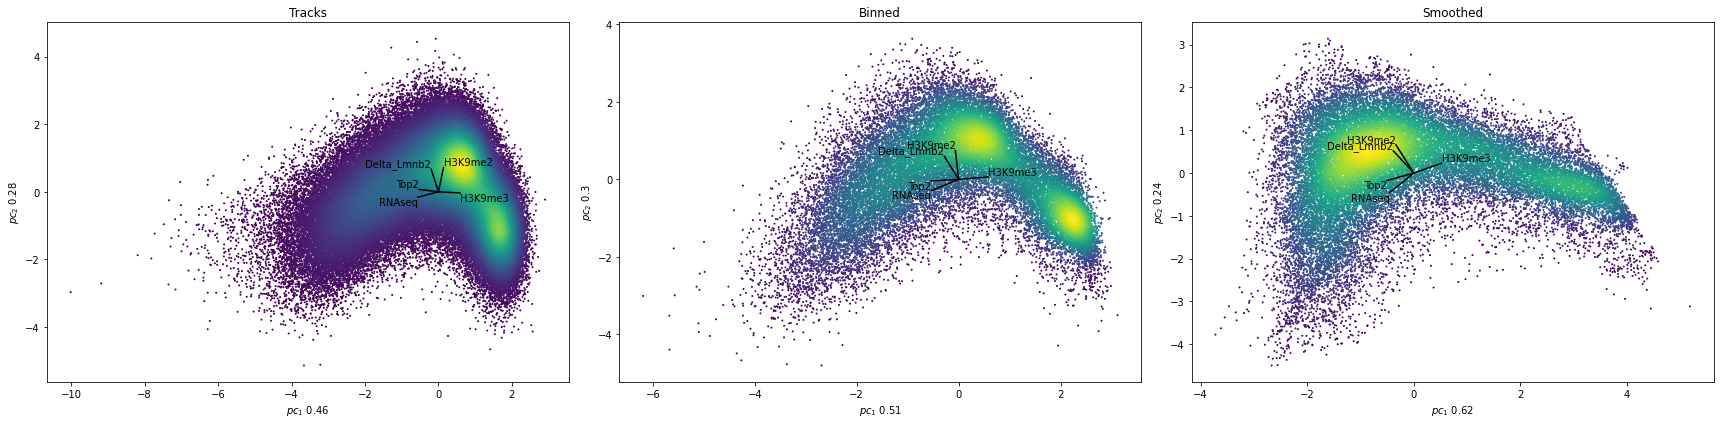

In [161]:
fig = plt.figure()
rows = 1
cols = 3
f=0

table_cols = ['Delta_Lmnb2','Top2','H3K9me2','H3K9me3','RNAseq']
table_cols = ['Delta_Lmnb2','Top2','H3K9me2','H3K9me3','RNAseq']

for my_table in ['Tracks','Binned','Smoothed']:
  print(my_table)
  X = tables[my_table][table_cols].values
  [U,S,V] = np.linalg.svd(X,full_matrices=False)
  sing_values = S**2
  pc_var = sing_values/np.sum(sing_values)
  score = np.dot(U,np.diag(S))

  
  f+=1
  ax = fig.add_subplot(rows,cols,f)
  z = gaussian_kde(score[:,[0,1]].T)(score[:,[0,1]].T)
  a = ax.scatter(x=score[:,0],y=score[:,1],c=z,s=1,alpha=1)
  for d in range(V.shape[1]):
    x = [0,V[0,d]]
    y = [0,V[1,d]]
    ax.plot(x,y,'k-')
    if x[1]<0:
      ha='right'
    else:
      ha='left'
    if y[1]<0:
      va='top'
    else:
      va='bottom'
      
    ax.text(x[1],y[1],table_cols[d],ha=ha,va=va)
  ax.set_xlabel(f'$pc_1$ {np.round(pc_var[0],2)}')
  ax.set_ylabel(f'$pc_2$ {np.round(pc_var[1],2)}')
  ax.set_title(my_table)
  
fig.set_size_inches([cols*8,rows*6])
plt.tight_layout()

## Model fit

### Sigmoid on Top2/RNAseq

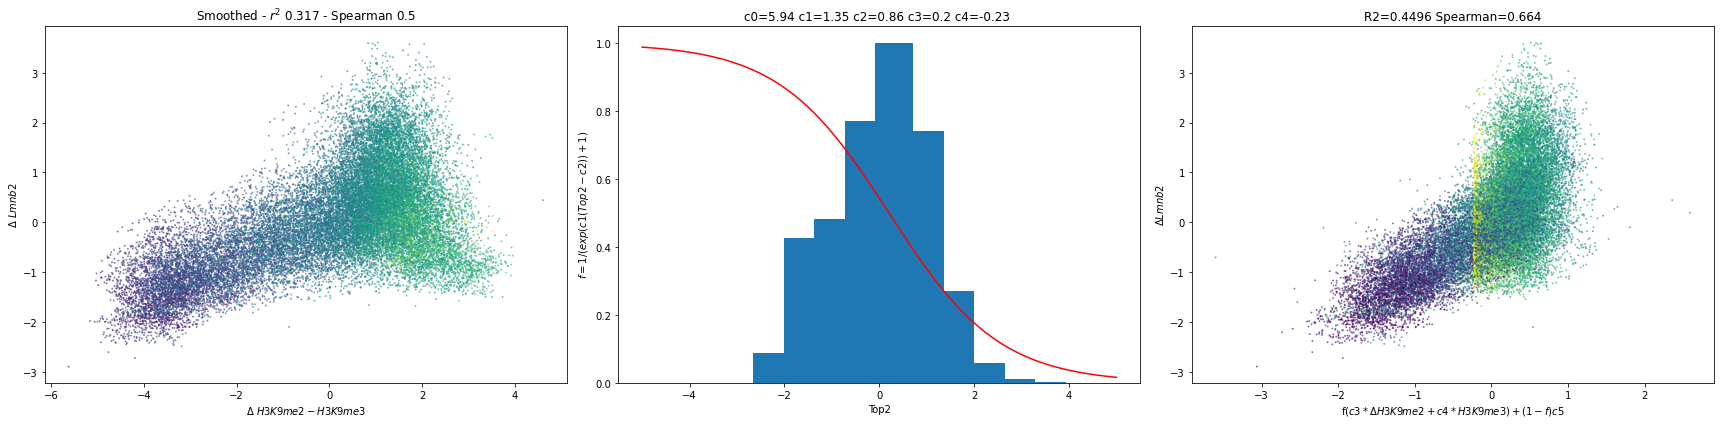

In [63]:
fig = plt.figure()
rows = 1
cols = 3
f=0

model_name = 'Top2_sigmoid'
SSR[model_name] = {}
R2[model_name] = {}
df[model_name] = {}
Spearman[model_name] = {}


def func(k,Tracks):
  f = 1/(np.exp(k[0]*(Tracks.Top2.values-k[1])) + 1)
  return np.array( f * (k[2]*Tracks.Delta_H3K9me2.values + k[3]*Tracks.H3K9me3.values ) + k[4]*(1-f) )

def rmsd(k,Tracks):
  f = 1/(np.exp(k[0]*(Tracks.Top2.values-k[1])) + 1)
  x = np.array( f * (k[2]*Tracks.Delta_H3K9me2.values + k[3]*Tracks.H3K9me3.values ) + k[4]*(1-f) )
  y = Tracks.Delta_Lmnb2.values
  return np.sqrt( np.mean( (x-y)*(x-y) ) )

for my_table in ['Smoothed']:

  tmp = tables[my_table].sort_values('Top2')
  y = tmp.Delta_Lmnb2
  x = tmp.Delta_H3K9me2 - tmp.H3K9me3
  c = tmp.Top2
  s = 1

  f+=1
  ax = fig.add_subplot(rows,cols,f)
  a = ax.scatter(x=x,y=y,c=c,s=s,alpha=.5)
  ax.set_title(f'{my_table} - $r^2$ {np.round(np.corrcoef(x,y)[0,1]**2,3)} - Spearman {np.round(scipy.stats.spearmanr(x,y)[0],2)}')
  ax.set_xlabel('$\Delta~H3K9me2 - H3K9me3$')
  ax.set_ylabel('$\Delta~Lmnb2$')
  
  k0 = np.array([1,0,1,1,1,1,0])
  k0 = np.array([1,0,1,1,0])
  res = minimize(rmsd, k0, args=tables[my_table])
  
  if res.success:
    x_ = np.arange(-5,5,0.001)
    f_ = 1/(np.exp(res.x[2]*(x_ - res.x[3]))+1)
    [h_,b_] = np.histogram(tables[my_table].Top2)
    b_ = (b_[:-1]+b_[1:])*.5
    h_ = h_/np.max(h_)

    f+=1
    ax = fig.add_subplot(rows,cols,f)
    ax.bar(b_,h_)
    ax.plot(x_,f_,'r')
    ax.set_xlabel('Top2')
    ax.set_ylabel(f'$f = 1/(exp(c1(Top2-c2))+1)$')
    my_tit = ''
    for n,k in enumerate(res.x):
      my_tit += f'c{n}={np.round(k,2)} '
    ax.set_title(my_tit)

    y = tables[my_table].Delta_Lmnb2
    y_pred = func(res.x,tables[my_table])
    c = tables[my_table].Top2
    s = 1

    SSR[model_name][my_table] = np.sum( (y-y_pred)**2 )
    df[model_name][my_table] = len(y) - len(k0)
    R2[model_name][my_table] = 1 - SSR[model_name][my_table]/SST[my_table]
    Spearman[model_name][my_table] = scipy.stats.spearmanr(y,y_pred)[0]


    f+=1
    ax = fig.add_subplot(rows,cols,f)
    a = ax.scatter(x=y_pred,y=y,c=c,s=s,alpha=.5,vmin=np.quantile(c,.01),vmax=np.quantile(c,.99))
    ax.set_ylabel('$\Delta Lmnb2$')
    ax.set_xlabel('f$(c3*\Delta H3K9me2 + c4*H3K9me3) + (1-f)c5$')
    ax.set_title(f'R2={np.round(R2[model_name][my_table],4)} Spearman={np.round(Spearman[model_name][my_table],3)}')
    
  else:
    f+=2
    SSR[model_name][my_table] = 0
    df[model_name][my_table] = 0

fig.set_size_inches([cols*8,rows*6])
plt.tight_layout()

#fig.savefig('/home/j.breda/Workspace/Modelling_Lmnb2_Top2_H3K9me2_H3K9me3_jb20220802/fig/scatter_Delta_Lamnb2.pdf')

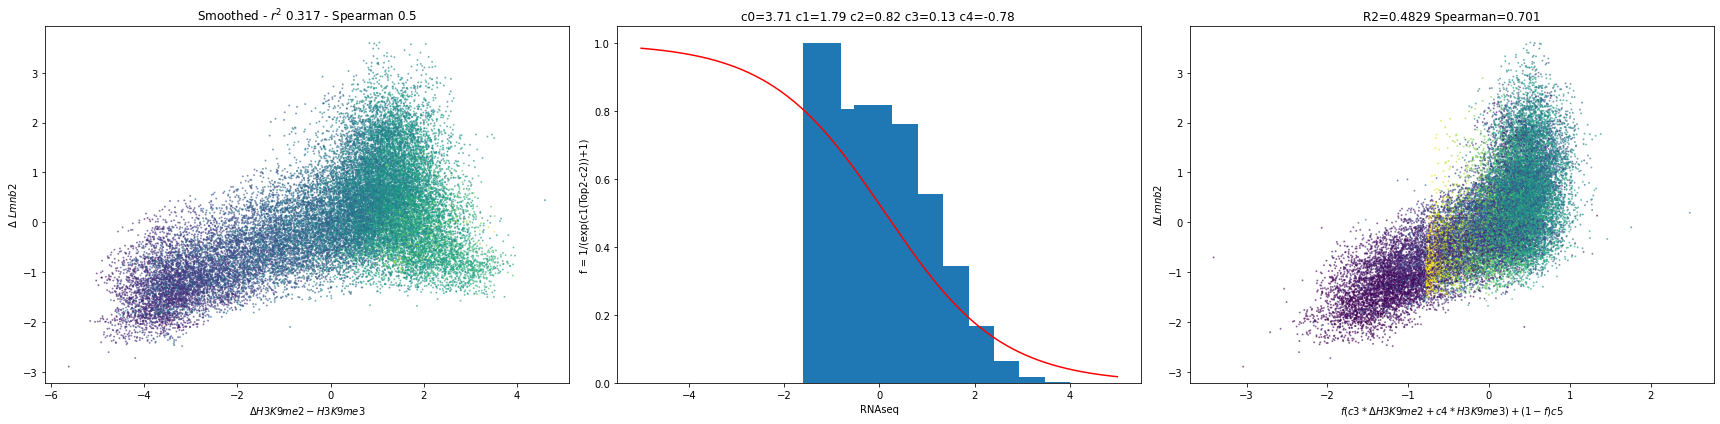

In [66]:
fig = plt.figure()
rows = 1
cols = 3
f=0

model_name = 'RNAseq_sigmoid'
SSR[model_name] = {}
R2[model_name] = {}
df[model_name] = {}
Spearman[model_name] = {}

def func(k,Tracks):
  f = 1/(np.exp(k[0]*(Tracks.RNAseq.values-k[1])) + 1)
  return np.array( f * (k[2]*Tracks.Delta_H3K9me2.values + k[3]*Tracks.H3K9me3.values ) + k[4]*(1-f) )

def rmsd(k,Tracks):
  f = 1/(np.exp(k[0]*(Tracks.RNAseq.values-k[1])) + 1)
  x = np.array( f * (k[2]*Tracks.Delta_H3K9me2.values + k[3]*Tracks.H3K9me3.values ) + k[4]*(1-f) )
  y = Tracks.Delta_Lmnb2.values
  return np.sqrt( np.mean( (x-y)*(x-y) ) )


for my_table in ['Smoothed']:

  tmp = tables[my_table].sort_values('RNAseq')
  y = tmp.Delta_Lmnb2
  x = tmp.Delta_H3K9me2 - tmp.H3K9me3
  c = tmp.Top2
  s = 1

  f+=1
  ax = fig.add_subplot(rows,cols,f)
  a = ax.scatter(x=x,y=y,c=c,s=s,alpha=.5)
  ax.set_title(f'{my_table} - $r^2$ {np.round(np.corrcoef(x,y)[0,1]**2,3)} - Spearman {np.round(scipy.stats.spearmanr(x,y)[0],2)}')
  ax.set_xlabel('$\Delta H3K9me2 - H3K9me3$')
  ax.set_ylabel('$\Delta~Lmnb2$')
  
  k0 = np.array([1,0,1,1,1,1,0])
  k0 = np.array([1,0,1,1,0])
  res = minimize(rmsd, k0, args=tables[my_table])
  
  if res.success:
    x_ = np.arange(-5,5,0.001)
    f_ = 1/(np.exp(res.x[2]*(x_ - res.x[3]))+1)
    [h_,b_] = np.histogram(tables[my_table].RNAseq)
    b_ = (b_[:-1]+b_[1:])*.5
    h_ = h_/np.max(h_)

    f+=1
    ax = fig.add_subplot(rows,cols,f)
    ax.bar(b_,h_)
    ax.plot(x_,f_,'r')
    ax.set_xlabel('RNAseq')
    ax.set_ylabel(f'f = 1/(exp(c1(Top2-c2))+1)')
    my_tit = ''
    for n,k in enumerate(res.x):
      my_tit += f'c{n}={np.round(k,2)} '
    ax.set_title(my_tit)

    y = tables[my_table].Delta_Lmnb2
    y_pred = func(res.x,tables[my_table])
    c = tables[my_table].RNAseq
    s = 1

    SSR[model_name][my_table] = np.sum( (y-y_pred)**2 )
    df[model_name][my_table] = len(y) - len(k0)
    R2[model_name][my_table] = 1 - SSR[model_name][my_table]/SST[my_table]
    Spearman[model_name][my_table] = scipy.stats.spearmanr(y,y_pred)[0]


    f+=1
    ax = fig.add_subplot(rows,cols,f)
    a = ax.scatter(x=y_pred,y=y,c=c,s=s,alpha=.5,vmin=np.quantile(c,.01),vmax=np.quantile(c,.99))
    ax.set_ylabel('$\Delta Lmnb2$')
    ax.set_xlabel('$f(c3*\Delta H3K9me2 + c4*H3K9me3) + (1-f)c5$')
    ax.set_title(f'R2={np.round(R2[model_name][my_table],4)} Spearman={np.round(Spearman[model_name][my_table],3)}')
    
  else:
    f+=2
    SSR[model_name][my_table] = 0
    df[model_name][my_table] = 0

fig.set_size_inches([cols*8,rows*6])
plt.tight_layout()


In [68]:
F = SSR['Top2_sigmoid']['Smoothed']/SSR['RNAseq_sigmoid']['Smoothed']
p = 1 - scipy.stats.f.cdf(F,df['Top2_sigmoid']['Smoothed'],df['RNAseq_sigmoid']['Smoothed'])
print(F)
print(p)

1.0000716838841706
0.4975899254842606


### Least square regression

all_vars
no_RNAseq
no_Top2
no_H3K9me3
no_H3K9me2_wt
no_H3K9me2_ko
avg_H3K9me2
delta_H3K9me2
no_Top2_no_H3K9me2_wt
no_Top2_avg_H3K9me2
no_Top2_delta_H3K9me2
no_Top2_no_H3K9me2_ko
no_Top2_no_H3K9me3
no_Top2_no_RNAseq
H3K9me2_ko_H3K9me3
H3K9me2_ko_RNAseq
H3K9me2_ko_Top2
H3K9me2_wt_H3K9me2_ko
H3K9me2_ko
H3K9me3


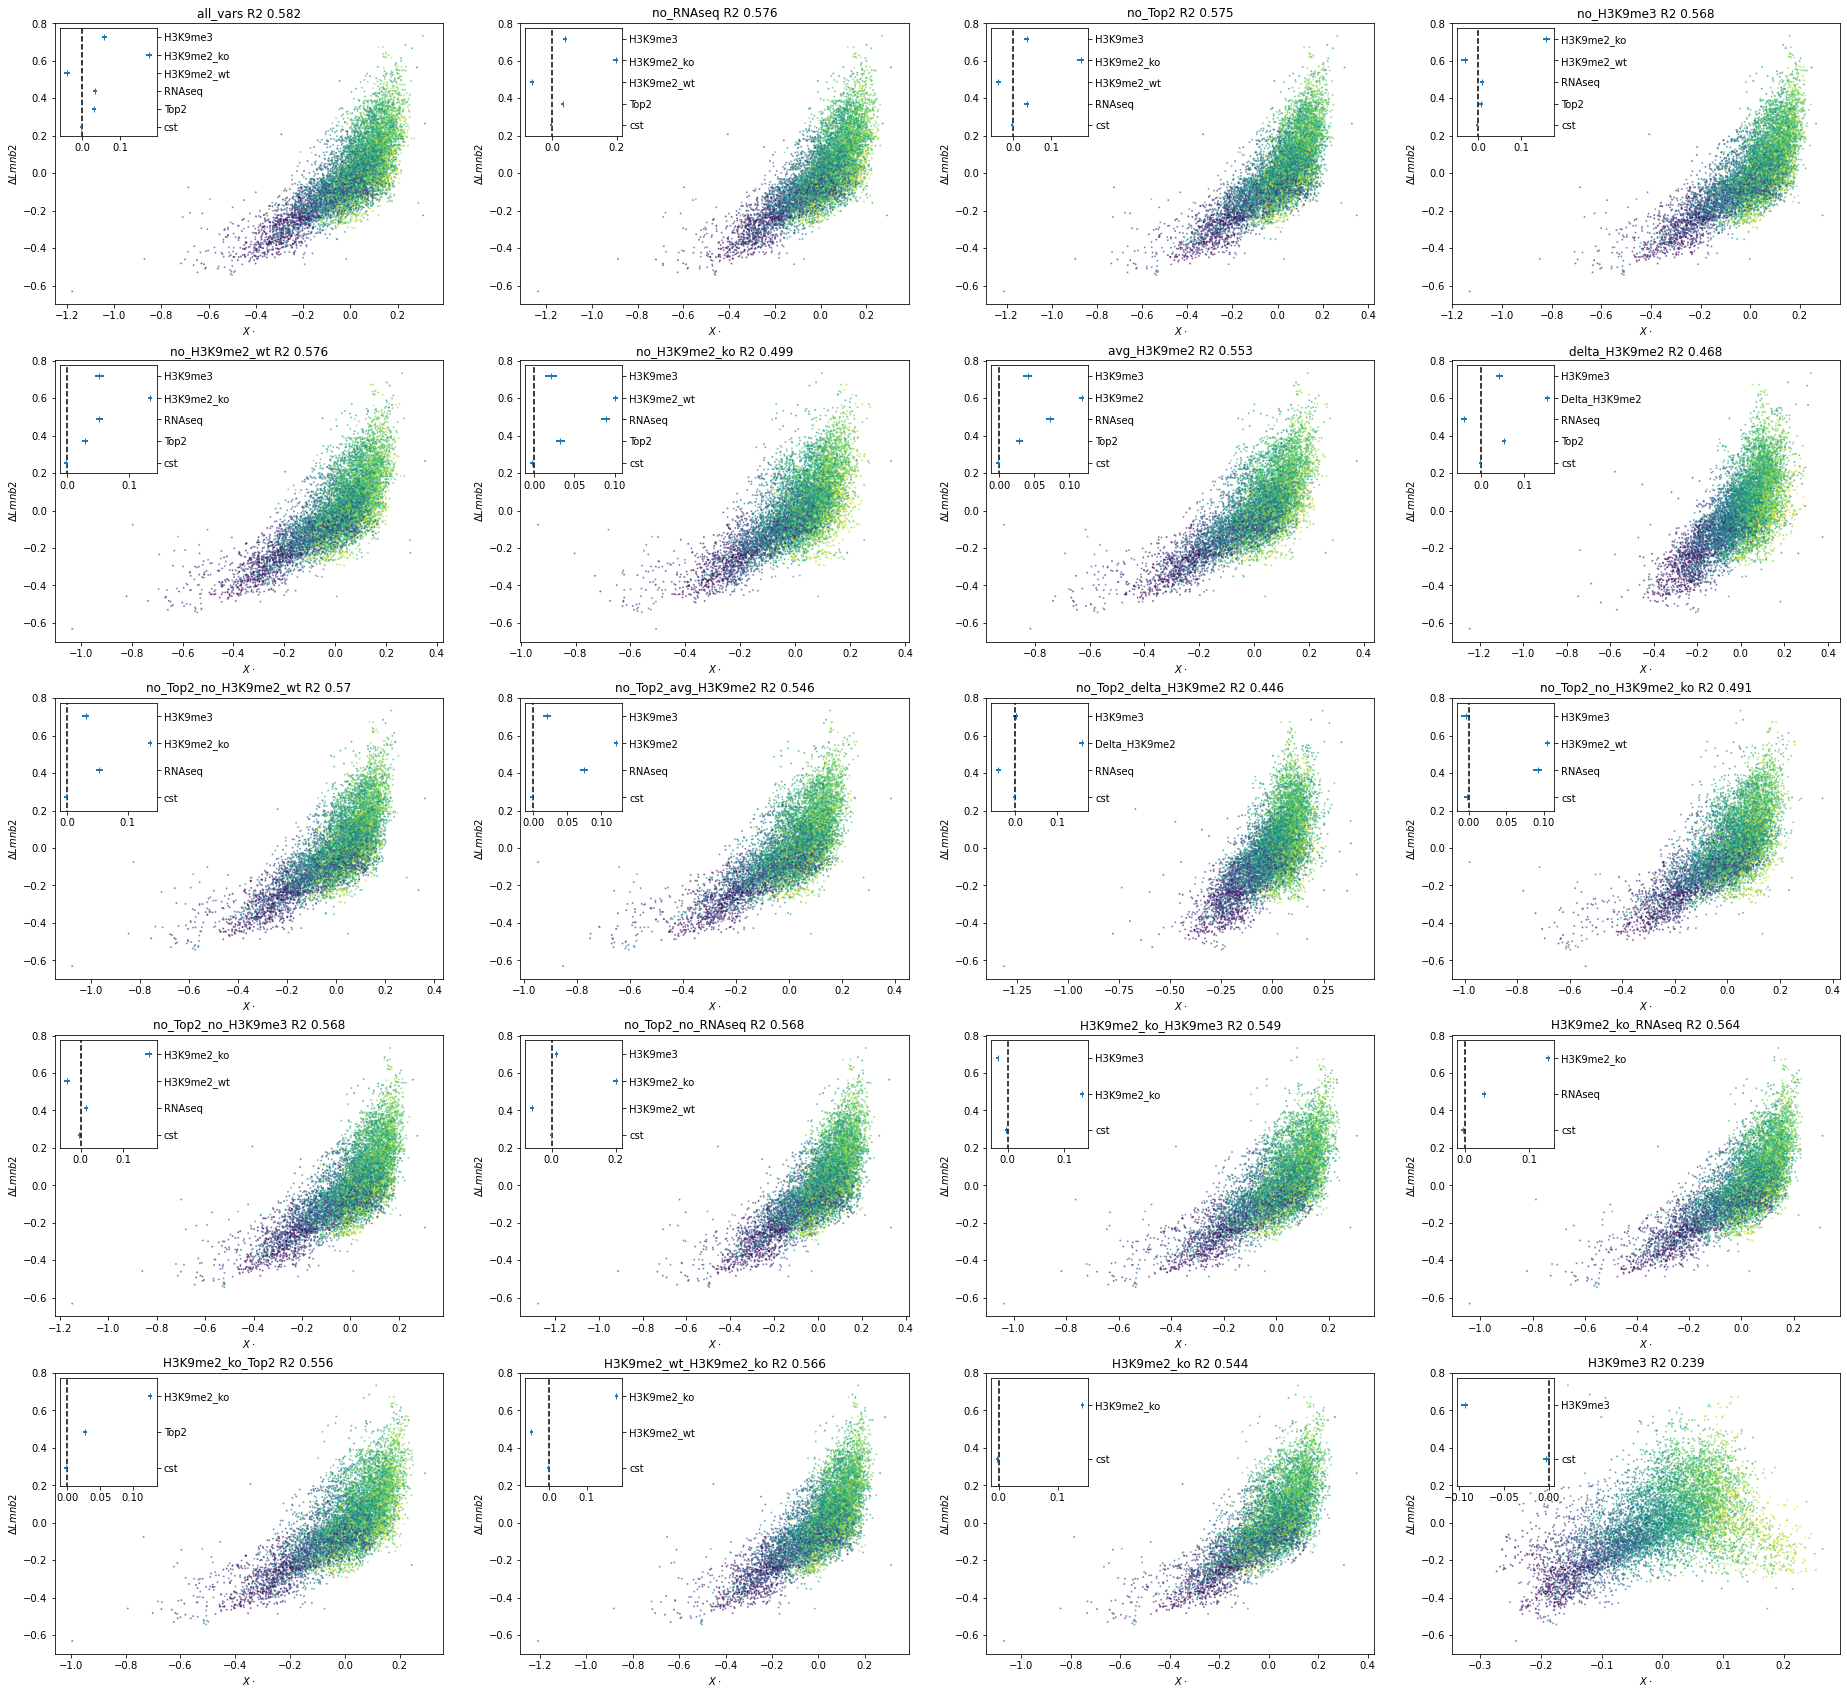

In [ ]:
MY_VARIABLES = {}
# 5 vars
MY_VARIABLES['all_vars'] = ['Top2','RNAseq','H3K9me2_wt','H3K9me2_ko','H3K9me3']
# 4 vars
MY_VARIABLES['no_RNAseq'] = ['Top2','H3K9me2_wt','H3K9me2_ko','H3K9me3']
MY_VARIABLES['no_Top2'] = ['RNAseq','H3K9me2_wt','H3K9me2_ko','H3K9me3']
MY_VARIABLES['no_H3K9me3'] = ['Top2','RNAseq','H3K9me2_wt','H3K9me2_ko']
MY_VARIABLES['no_H3K9me2_wt'] = ['Top2','RNAseq','H3K9me2_ko','H3K9me3']
MY_VARIABLES['no_H3K9me2_ko'] = ['Top2','RNAseq','H3K9me2_wt','H3K9me3']
MY_VARIABLES['avg_H3K9me2'] = ['Top2','RNAseq','H3K9me2','H3K9me3']
MY_VARIABLES['delta_H3K9me2'] = ['Top2','RNAseq','Delta_H3K9me2','H3K9me3']
# 3 vars
MY_VARIABLES['no_Top2_no_H3K9me2_wt'] = ['RNAseq','H3K9me2_ko','H3K9me3']
MY_VARIABLES['no_Top2_avg_H3K9me2'] = ['RNAseq','H3K9me2','H3K9me3']
MY_VARIABLES['no_Top2_delta_H3K9me2'] = ['RNAseq','Delta_H3K9me2','H3K9me3']
MY_VARIABLES['no_Top2_no_H3K9me2_ko'] = ['RNAseq','H3K9me2_wt','H3K9me3']
MY_VARIABLES['no_Top2_no_H3K9me3'] = ['RNAseq','H3K9me2_wt','H3K9me2_ko']
MY_VARIABLES['no_Top2_no_RNAseq'] = ['H3K9me2_wt','H3K9me2_ko','H3K9me3']
# 2 vars
MY_VARIABLES['H3K9me2_ko_H3K9me3'] = ['H3K9me2_ko','H3K9me3']
MY_VARIABLES['H3K9me2_ko_RNAseq'] = ['RNAseq','H3K9me2_ko']
MY_VARIABLES['H3K9me2_ko_Top2'] = ['Top2','H3K9me2_ko']
MY_VARIABLES['H3K9me2_wt_H3K9me2_ko'] = ['H3K9me2_wt','H3K9me2_ko']
# 1 var
MY_VARIABLES['H3K9me2_ko'] = ['H3K9me2_ko']
MY_VARIABLES['H3K9me3'] = ['H3K9me3']


fig = plt.figure()
rows = int(np.ceil(len(MY_VARIABLES)/4))
cols = 4
f=0

for model_name in MY_VARIABLES:
  print(model_name)
  SSR[model_name] = {}
  R2[model_name] = {}
  df[model_name] = {}
  Spearman[model_name] = {}
  my_variables = MY_VARIABLES[model_name]
  for my_table in ['Smoothed']:
    X = np.concatenate([np.ones([tables[my_table].shape[0],1]),tables[my_table][my_variables].values],axis=1)
    y = tables[my_table]['Delta_Lmnb2'].values[:,np.newaxis]
    # covariance matrix
    C = np.linalg.inv(np.dot(X.T,X))
    # parameters estimates
    beta = np.dot( C, np.dot(X.T,y) )
    # prediction
    y_pred = np.dot(X,beta)
    [n,m] = X.shape
    S = np.sum( (y-y_pred)**2 )
    sigma2_beta = S/(n-m)*np.diag(C)
    
    # sum of squared residual
    SSR[model_name][my_table] = S
    df[model_name][my_table] = n - m
    R2[model_name][my_table] = 1 - SSR[model_name][my_table]/SST[my_table]
    Spearman[model_name][my_table] = scipy.stats.spearmanr(y,y_pred)[0]

    c = tables[my_table].Top2
    s = 1
    r = np.corrcoef(np.concatenate([y,y_pred],axis=1).T)[0,1]
    rmsd = np.sqrt( np.mean( (y - y_pred)**2) )
    b = [np.round(b[0],3) for b in beta]

    # plot true Delta Lmnb2 vs. prediction
    f+=1
    ax = fig.add_subplot(rows,cols,f)
    a = ax.scatter(x=y_pred,y=y,c=c,s=s,alpha=.5,vmin=np.quantile(c,.01),vmax=np.quantile(c,.99))
    ax.set_ylabel('$\Delta Lmnb2$')
    ax.set_xlabel('$ X \cdot \beta $')
    my_tit = f'{model_name} R2 {np.round(R2[model_name][my_table],3)} - Spearman {np.round(Spearman[model_name][my_table],3)}'
    ax.set_title(my_tit)

    # plot paramter significance
    ax_inset = inset_axes(ax,
                    width="25%", # width = 30% of parent_bbox
                    height=1.5, # height : 1 inch
                    loc=2) # 2: upper left
    #left, bottom, width, height = [0.05, 0.7, 0.25, 0.25]
    #ax_inset = fig.add_axes([left, bottom, width, height])
    a = ax_inset.plot([0,0],[-1,m],'k--')
    a = ax_inset.errorbar(beta,np.arange(m),xerr=2*np.sqrt(sigma2_beta),yerr=None,fmt='|',ls='',lw=2)
    ax_inset.set_ylim([-.5,m-.5])
    ax_inset.set_yticks(np.arange(m))
    ax_inset.set_yticklabels(['cst']+my_variables)
    ax_inset.yaxis.tick_right()
  
fig.set_size_inches([cols*8,rows*6])

#### Chosen model

H3K9me2_wt_H3K9me3_wt_Top2_RNAseq
H3K9me2_wt_H3K9me3_wt_RNAseq
H3K9me2_wt_H3K9me3_wt_Top2


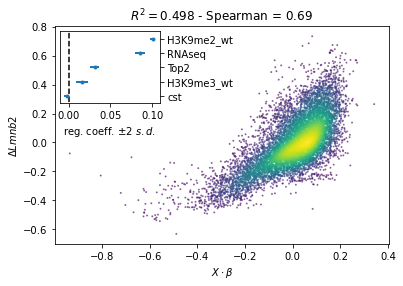

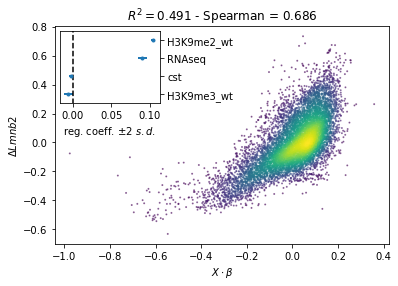

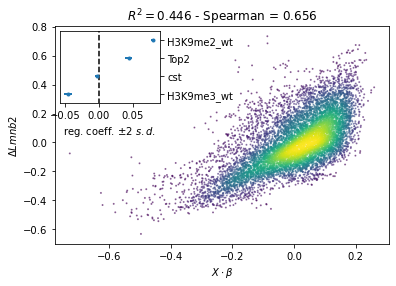

In [18]:
MY_VARIABLES = {}
# 5 vars
MY_VARIABLES['H3K9me2_wt_H3K9me3_wt_Top2_RNAseq'] = ['H3K9me2_wt','H3K9me3_wt','Top2','RNAseq']
MY_VARIABLES['H3K9me2_wt_H3K9me3_wt_RNAseq'] = ['H3K9me2_wt','H3K9me3_wt','RNAseq']
MY_VARIABLES['H3K9me2_wt_H3K9me3_wt_Top2'] = ['H3K9me2_wt','H3K9me3_wt','Top2']


for model_name in MY_VARIABLES:
  print(model_name)
  SSR[model_name] = {}
  R2[model_name] = {}
  df[model_name] = {}
  Spearman[model_name] = {}
  my_variables = MY_VARIABLES[model_name]
  
  fig = plt.figure()
  rows = 1
  cols = 1
  f=0

  for my_table in ['Smoothed']:
    X = np.concatenate([np.ones([tables[my_table].shape[0],1]),tables[my_table][my_variables].values],axis=1)
    y = tables[my_table]['Delta_Lmnb2'].values[:,np.newaxis]
    # covariance matrix
    C = np.linalg.inv(np.dot(X.T,X))
    # parameters estimates
    beta = np.dot( C, np.dot(X.T,y) )
    # prediction
    y_pred = np.dot(X,beta)
    [n,m] = X.shape
    S = np.sum( (y-y_pred)**2 )
    sigma2_beta = S/(n-m)*np.diag(C)
    
    # sum of squared residual
    SSR[model_name][my_table] = S
    df[model_name][my_table] = n - m
    R2[model_name][my_table] = 1 - SSR[model_name][my_table]/SST[my_table]
    Spearman[model_name][my_table] = scipy.stats.spearmanr(y,y_pred)[0]

    #c = tables[my_table].Top2
    xy = np.hstack([y_pred,y]).T
    z = gaussian_kde(xy)(xy)
    s = 1
    r = np.corrcoef(np.concatenate([y,y_pred],axis=1).T)[0,1]
    rmsd = np.sqrt( np.mean( (y - y_pred)**2) )
    b = [np.round(b[0],3) for b in beta]

    # plot true Delta Lmnb2 vs. prediction
    f+=1
    ax = fig.add_subplot(rows,cols,f)
    a = ax.scatter(x=y_pred,y=y,c=z,s=s,alpha=.5,rasterized=True)
    ax.set_ylabel('$\Delta Lmnb2$')
    ax.set_xlabel(r'$X \cdot \beta$')
    my_tit = f'$R^2 = ${np.round(R2[model_name][my_table],3)} - Spearman = {np.round(Spearman[model_name][my_table],3)}'
    ax.set_title(my_tit)

    # plot paramter significance
    # sort coeff by value
    idx_sort = np.argsort(beta[:,0])
    label = np.array(['cst']+my_variables)
    label = label[idx_sort]
    ax_inset = inset_axes(ax,
                    width="30%", # width = 30% of parent_bbox
                    height="33%", # height : 1 inch
                    loc=2) # 2: upper left
    #left, bottom, width, height = [0.05, 0.7, 0.25, 0.25]
    #ax_inset = fig.add_axes([left, bottom, width, height])
    a = ax_inset.plot([0,0],[-1,m],'k--')
    a = ax_inset.errorbar(beta[idx_sort],np.arange(m),xerr=2*np.sqrt(sigma2_beta[idx_sort]),yerr=None,fmt='.',ls='',lw=2)
    ax_inset.set_ylim([-.5,m-.5])
    ax_inset.set_yticks(np.arange(m))
    ax_inset.set_yticklabels(label)
    ax_inset.yaxis.tick_right()
    ax_inset.set_xlabel('reg. coeff. $\pm 2~s.d.$')

  fig.set_size_inches([cols*6,rows*4])
  fig.savefig(f"../fig/Least_square_regression_Delta_Lmnb2_{'_'.join(my_variables)}.pdf",dpi=300)

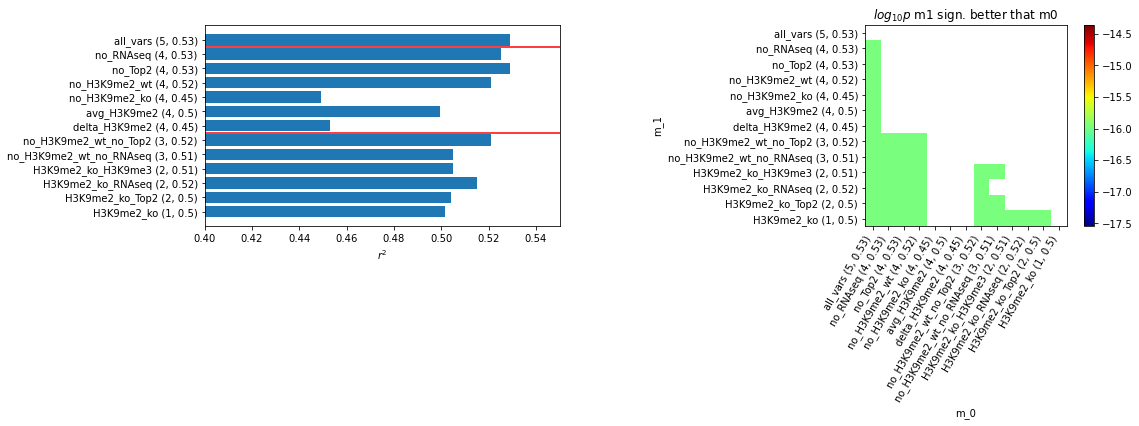

In [21]:
# F-test
n_models = len(MY_VARIABLES)
F = np.zeros([n_models,n_models])
F[:] = np.nan
p = np.zeros([n_models,n_models])
p[:] = np.nan
my_table = 'Smoothed'
for i,m0 in enumerate(MY_VARIABLES):
  for j,m1 in enumerate(MY_VARIABLES):
    if i!=j:
      #if df[m1][my_table]==df[m2][my_table]:
      #  F[i,j] = SSR[m1][my_table]/SSR[m2][my_table]
      #  p[i,j] = 1 - scipy.stats.f.cdf(F[i,j],df[m1][my_table],df[m2][my_table])
      if (df[m0][my_table] > df[m1][my_table]) and (R2[m0][my_table] < R2[m1][my_table]):
        F[i,j] = ( (SSR[m0][my_table]-SSR[m1][my_table])/( df[m0][my_table]-df[m1][my_table]) )/( SSR[m0][my_table]/df[m0][my_table] )
        p[i,j] = 1-scipy.stats.f.cdf(F[i,j],df[m1][my_table],df[m0][my_table])
                                    

my_ticks = [v for v in MY_VARIABLES.keys()]
my_ticks = [f'{t} ({len(MY_VARIABLES[t])}, {np.round(R2[t][my_table],2)})' for t in MY_VARIABLES.keys()]
          
fig = plt.figure()
rows = 1
cols = 2
f=0

f+=1
r2 = np.array( [R2[m][my_table] for m in MY_VARIABLES] )
ax = fig.add_subplot(rows,cols,f)
ax.barh(range(n_models),r2)
xlim=ax.get_xlim()
ax.plot(xlim,[0.5]*2,'r')
ax.plot(xlim,[6.5]*2,'r')
plt.xlabel('$r^2$')
plt.yticks(range(n_models),my_ticks)
plt.xlim([0.4,0.55])
ax.invert_yaxis()

#plt.title("$log_{10} p$ m1 sign. better that m0")

f+=1
ax = fig.add_subplot(rows,cols,f)
a = ax.imshow(np.log10(p),cmap='jet')
fig.colorbar(a)
plt.xticks(range(n_models),my_ticks, rotation = 60, ha="right")
plt.yticks(range(n_models),my_ticks)
plt.xlabel('m_0')
plt.ylabel('m_1')
plt.title("$log_{10} p$ m1 sign. better that m0")


fig.set_size_inches([cols*8,rows*6])
plt.tight_layout()
    
    

In [98]:
MY_VARIABLES = {}
MY_VARIABLES['all_vars'] = ['Top2','RNAseq','H3K9me2_wt','H3K9me2_ko','H3K9me3']
MY_VARIABLES['no_RNAseq'] = ['Top2','H3K9me2_wt','H3K9me2_ko','H3K9me3']
MY_VARIABLES['no_Top2'] = ['RNAseq','H3K9me2_wt','H3K9me2_ko','H3K9me3']
MY_VARIABLES['no_H3K9me2wt'] = ['Top2','RNAseq','H3K9me2_ko','H3K9me3']
MY_VARIABLES['no_H3K9me2ko'] = ['Top2','RNAseq','H3K9me2_wt','H3K9me3']
MY_VARIABLES['avg_H3K9me2'] = ['Top2','RNAseq','H3K9me2','H3K9me3']
MY_VARIABLES['delta_H3K9me2'] = ['Top2','RNAseq','Delta_H3K9me2','H3K9me3']
MY_VARIABLES['no_Top2_no_H3K9me2wt'] = ['RNAseq','H3K9me2_ko','H3K9me3']
MY_VARIABLES['no_RNAseq_no_H3K9me2wt'] = ['Top2','H3K9me2_ko','H3K9me3']

fig = plt.figure()
rows = int(np.ceil(len(MY_VARIABLES)/3))
cols = 3
f=0

for model_name in MY_VARIABLES:
  print(model_name)
  SSR[model_name] = {}
  R2[model_name] = {}
  df[model_name] = {}
  Spearman[model_name] = {}
  my_variables = MY_VARIABLES[model_name]
  for my_table in ['Smoothed']:
    X = np.concatenate([np.ones([tables[my_table].shape[0],1]),tables[my_table][my_variables].values],axis=1)
    y = tables[my_table]['Delta_Lmnb2'].values[:,np.newaxis]
    # covariance matrix
    C = np.linalg.inv(np.dot(X.T,X))
    # parameters estimates
    beta = np.dot( C, np.dot(X.T,y) )
    # prediction
    y_pred = np.dot(X,beta)
    [n,m] = X.shape
    S = np.sum( (y-y_pred)**2 )
    sigma2_beta = S/(n-m)*np.diag(C)
    
    # sum of squared residual
    SSR[model_name][my_table] = S
    df[model_name][my_table] = n - m
    R2[model_name][my_table] = 1 - SSR[model_name][my_table]/SST[my_table]
    Spearman[model_name][my_table] = scipy.stats.spearmanr(y,y_pred)[0]

    c = tables[my_table].Top2
    s = 1
    r = np.corrcoef(np.concatenate([y,y_pred],axis=1).T)[0,1]
    rmsd = np.sqrt( np.mean( (y - y_pred)**2) )
    b = [np.round(b[0],3) for b in beta]

    # plot true Delta Lmnb2 vs. prediction
    f+=1
    ax = fig.add_subplot(rows,cols,f)
    a = ax.scatter(x=y_pred,y=y,c=c,s=s,alpha=.5,vmin=np.quantile(c,.01),vmax=np.quantile(c,.99))
    ax.set_ylabel('$\Delta Lmnb2$')
    ax.set_xlabel('$ X \cdot \beta $')
    my_tit = f'{model_name} R2 {np.round(R2[model_name][my_table],3)} - Spearman {np.round(Spearman[model_name][my_table],3)}'
    ax.set_title(my_tit)

    # plot paramter significance
    ax_inset = inset_axes(ax,
                    width="25%", # width = 30% of parent_bbox
                    height=1.5, # height : 1 inch
                    loc=2) # 2: upper left
    #left, bottom, width, height = [0.05, 0.7, 0.25, 0.25]
    #ax_inset = fig.add_axes([left, bottom, width, height])
    a = ax_inset.plot([0,0],[-1,m],'k--')
    a = ax_inset.errorbar(beta,np.arange(m),xerr=3*np.sqrt(sigma2_beta),yerr=None,fmt='|',ls='',lw=2)
    ax_inset.set_ylim([-.5,m-.5])
    ax_inset.set_yticks(np.arange(m))
    ax_inset.set_yticklabels(['cst']+my_variables)
    ax_inset.yaxis.tick_right()
  
fig.set_size_inches([cols*8,rows*6])
#plt.tight_layout()

array([0.52891952, 0.52508098, 0.52887183, 0.52113044, 0.44900893,
       0.49934824, 0.45310947, 0.47388252, 0.49926365, 0.43186394,
       0.45149918])